In [4]:
%load_ext autoreload
%autoreload 2
import glob
import matplotlib.pyplot as plt
from matplotlib import cycler
import datetime
import pandas as pd
import os
import helper
import numpy as np
import seaborn as sns
import itertools
import json

import helper


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hotfile = "satellite_data/1/15/1.1Mbps/"

In [3]:


cycler_colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#CF4457', '#188487', '#E24A33']
def set_matplot_params(font_size = 8, xtick_major = 0.25, xtick_minor = 0.25, ytick_major = 0.25, ytick_minor = 0.25):
    params_dict = {
        'text.usetex': False,
        # 'font.family': 'Times New Roman',
        # 'font.serif': 'Times New Roman',
        # 'font.sans-serif': 'Times New Roman',
        'font.size': font_size,
        'figure.figsize': [3.125, 1.93],  # Golden ratio
        #figure.figsize: 3.125, 1.56  # Squash for more space
        'legend.fontsize': 6,
        'legend.fancybox': False,
        'axes.linewidth': 0.5,
        'pdf.fonttype' : 42,
        'ps.fonttype' : 42,
        'axes.prop_cycle': cycler("color", cycler_colors),
                          # 348ABD : blue
                          # A60628 : red
                          # 7A68A6 : purple
                          # 467821 : green
                          # CF4457 : pink
                          # 188487 : turquoise
                          # E24A33 : orange
        'patch.linewidth': 0.5,
        'lines.linewidth': 2,
        'grid.linewidth': 0.1,
        'xtick.major.width': xtick_major,
        'xtick.minor.width': xtick_minor,
        'ytick.major.width': ytick_major,
        'ytick.minor.width': ytick_minor,
        'legend.numpoints': 1}
    plt.rcParams.update(params_dict)
set_matplot_params()

In [4]:
import numpy as np
import pandas as pd

# Function to convert bitrate from "XXXX Kbps" to a numeric value
def convert_bitrate(bitrate):
    try:
        return float(bitrate.replace(" Kbps", ""))
    except ValueError:
        return np.nan

def load_csv(filepath, skip_ads=True):
    # Define the expected column names
    columns = ["timeStamp", "Video Resolution", "Display Resolution", "FPS", "Skipped Frames",
               "Buffer Size", "Latency To Broadcaster", "Latency Mode", "Playback Bitrate",
               "Backend Version", "Serving ID", "Codecs", "Play Session ID", "Protocol", "isRebuffering", "inAd"]

    # Load the CSV data without specifying column names
    df = pd.read_csv(filepath, header=None)

    # Assign the correct column names
    df.columns = columns

    if skip_ads:
        # filter out the rows where inAd is True
        df = df[df['inAd'] == 'False']

    # Apply the conversion to the 'Playback Bitrate' column
    df['Playback Bitrate'] = df['Playback Bitrate'].apply(convert_bitrate)

    return df


In [5]:

# def load_and_calculate_average_bitrate(filepath):
#     # Load the data with corrected values
#     corrected_data = load_csv(filepath, skip_ads=False)
    
#     # Calculate the average bitrate
#     average_bitrate = corrected_data['Playback Bitrate'].mean() / 1000

#     return average_bitrate

# load_and_calculate_average_bitrate(hotfile)


def load_and_calculate_average_bitrate(filepath):
    # Load the data with corrected values
    corrected_data = load_csv(filepath, skip_ads=True)
    
    bitrate_values_w_times = []

    # Iterate over the rows of the dataframe starting at the second row
    # set the current bitrate to the playback bitrate
    # set the time value to the difference between times of this row and the one before
    # append the current bitrate and time to the list
    for i in range(1, len(corrected_data)):
        current_bitrate = corrected_data.iloc[i]['Playback Bitrate']

        if not corrected_data.iloc[i]['timeStamp'].isnumeric():
            continue
        if not corrected_data.iloc[i-1]['timeStamp'].isnumeric():
            continue

        # convert corrected_data.iloc[i]['timeStamp'] to an integer if it is numeric
        current_time = int(corrected_data.iloc[i]['timeStamp']) 
        previous_time = int(corrected_data.iloc[i-1]['timeStamp'])
        
        time = current_time - previous_time
        bitrate_values_w_times.append((current_bitrate, time))

    # do a weigthed average of the bitrates by their time
    weighted_bitrate = sum([bitrate * time for bitrate, time in bitrate_values_w_times])
    # set total time to the sum of all times
    total_time = sum([time for bitrate, time in bitrate_values_w_times])
    
    average_bitrate = weighted_bitrate / total_time

    if average_bitrate == 0:
        print("Average bitrate is 0: ", filepath)

    return average_bitrate / 1000

load_and_calculate_average_bitrate(hotfile)

0.3519381502372152

In [6]:
# helper functions to calculate mean pixel value
def resolution_to_pixels(resolution):
    width, height = map(int, resolution.split('x'))
    # return width * height
    return height

def load_and_calculate_mean_pixel(filepath):
    # Load the data with corrected values
    corrected_data = load_csv(filepath)

    # filter out the rows where inAd is True
    corrected_data = corrected_data[corrected_data['inAd'] == 'False']

    # filter out the rows where FPS is ''
    corrected_data = corrected_data[corrected_data['FPS'].apply(lambda x: str(x) == 'nan')]
    
    # Calculate the average bitrate
    pixel_array = [resolution_to_pixels(resolution) for resolution in corrected_data['Video Resolution'][1:]]
    average_bitrate = np.mean(pixel_array)

    return average_bitrate

load_and_calculate_mean_pixel(hotfile)

131.8153846153846

In [7]:
def count_time_rebuffering(filepath):
        # Load the CSV data
        df = load_csv(filepath, skip_ads=True)
        
        rebuffering_times = []
        rebuffering_start_time = None
        
        # Iterate through the rows of df
        for index, row in df.iterrows():
            # if row['isRebuffering'] == 'True':
            if str(row['FPS']) == 'nan':
                # If the current row is the start of a new ad chunk, record the start time
                if rebuffering_start_time is None:
                    rebuffering_start_time = int(row['timeStamp'])
                    rebuffering_times.append(0)
                else:
                    # If the current row is part of an ad chunk, set the index of the last element of ad_chunk_times to the current time - start time
                    rebuffering_times[-1] = (int(row['timeStamp']) - rebuffering_start_time) / 1000
            else:
                # If the current row is not part of an ad chunk, reset the start time
                rebuffering_start_time = None
        
        # Calculate the total time spent in ads
        time_spent_rebuffering = sum(rebuffering_times)
        
        return time_spent_rebuffering, len(rebuffering_times)

count_time_rebuffering(hotfile)


(149.58499999999998, 10)

In [8]:
def count_resolution_changes(filepath):
    # Load the CSV data
    df = load_csv(filepath, skip_ads=True)
    
    # Assume 'Video Resolution' is the correct column name
    # Count the resolution changes by comparing each row with the next row
    resolution_changes = (df['Video Resolution'].shift(1) != df['Video Resolution']).sum()
    
    # The first comparison is always NaN because there is no previous row for the first row,
    # so we subtract 1 from the count
    resolution_changes -= 1
    
    return resolution_changes

count_resolution_changes(hotfile)

9

In [9]:
def count_time_spent_in_ads(filepath):
        # Load the CSV data
        df = load_csv(filepath, skip_ads=False)
        
        ad_chunk_times = []
        ad_chunk_start_time = None
        
        # Iterate through the rows of df
        for index, row in df.iterrows():
            if row['inAd'] == 'True':
                # If the current row is the start of a new ad chunk, record the start time
                if ad_chunk_start_time is None:
                    ad_chunk_start_time = int(row['timeStamp'])
                    ad_chunk_times.append(0)
                else:
                    # If the current row is part of an ad chunk, set the index of the last element of ad_chunk_times to the current time - start time
                    ad_chunk_times[-1] = (int(row['timeStamp']) - ad_chunk_start_time) / 1000
            else:
                # If the current row is not part of an ad chunk, reset the start time
                ad_chunk_start_time = None
        
        # Calculate the total time spent in ads
        time_spent_in_ads = sum(ad_chunk_times)
        
        return time_spent_in_ads, len(ad_chunk_times)

count_time_spent_in_ads(hotfile)

(132.246, 2)

In [10]:
# helper functions to convert latency string to seconds as in
def latency_to_float(str):
    value, _ = str.split(' ')
    value = float(value)
    return value

def calculate_latency_and_buffer_stats(filepath): 
    # Load the CSV data
    df = load_csv(filepath, skip_ads=True)

    # filter csv only to rows where FPS str(row['FPS']) == 'nan' by iterating through it and changinge the values for string comparison
    df = df[df['FPS'].apply(lambda x: str(x) == 'nan')]
    

    # if the length of the df is 0, return 0 for all values
    if len(df) == 0:
        print("ERROR WITH FILE: ", filepath)
        return 0, 0, 0, 0, 0

    low_latency_mode = df[df['Latency Mode'] == 'Low Latency']
    percent_low_latency = len(low_latency_mode) / len(df)
    
    

    # convert the dataframe series to a list of pixel values in an explicit for loop using helper function in a for loop that prints the row values as it iterates
    latency_values = []
    buffer_values = []

    for index, row in low_latency_mode.iterrows():
        latency_values.append(latency_to_float(row['Latency To Broadcaster']))
        buffer_values.append(latency_to_float(row['Buffer Size']))




    

    # Calculate the average latency
    average_latency = np.mean(latency_values)
    average_buffer = np.mean(buffer_values)

    # Calculate the standard deviation of the latency
    std_latency = np.std(latency_values)
    std_buffer = np.std(buffer_values)

    return average_latency, std_latency, percent_low_latency, average_buffer, std_buffer

calculate_latency_and_buffer_stats(hotfile)
    

(22.80237113402062,
 16.732027426477757,
 0.7432950191570882,
 2.65020618556701,
 2.887183009558519)

# Organizing Data Vectors

In [11]:
# Initialize an empty list to store the vectors
data_vectors = []

def loop_through_csv_files(root_dir):
    data = []
    
    # Loop through the network folders of the root directory
    for network in os.listdir(root_dir):
        network_dir = os.path.join(root_dir, network)

        # Loop through the subfolders of the network directory
        for game_folder in os.listdir(network_dir):
            game_folder_path = os.path.join(network_dir, game_folder)
            
            # Check if the subfolder is a directory
            if os.path.isdir(game_folder_path):
                
                # Loop through the shaping rate folders
                for shaping_rate_folder in os.listdir(game_folder_path):
                    shaping_rate_folder_path = os.path.join(game_folder_path, shaping_rate_folder)
                    
                    # Check if the subfolder is a directory
                    if os.path.isdir(shaping_rate_folder_path):
                        
                        # Loop through the CSV files
                        for file in os.listdir(shaping_rate_folder_path):
                            file_path = os.path.join(shaping_rate_folder_path, file)
                            
                            # Check if the file is a CSV file and the file has at least 3 rows
                            if file.endswith('.csv') and sum(1 for line in open(file_path)) > 3:

                                category = helper.game_to_category(game_folder)

                                # Extract the shaping rate and grandparent folder names
                                shaping_rate = shaping_rate_folder
                                grandparent_folder = os.path.basename(os.path.dirname(game_folder_path))
                                
                                # Calculate the average bitrate for each CSV file
                                average_bitrate = load_and_calculate_average_bitrate(file_path)
                                
                                # Calculate the mean pixel value for each CSV file
                                mean_pixel = load_and_calculate_mean_pixel(file_path)

                                # Calculate the rebuffering events for each CSV file
                                time_rebuffering, rebuffering_events = count_time_rebuffering(file_path)

                                # Calculate the resolution changes for each CSV file
                                resolution_changes = count_resolution_changes(file_path)

                                # Calculate the time spent in ads for each CSV file
                                time_spent_in_ads, num_ads = count_time_spent_in_ads(file_path)

                                # Calculate the latency statistics for each CSV file
                                average_latency, std_latency, percent_low_latency, average_buffer, std_buffer = calculate_latency_and_buffer_stats(file_path)
                                
                                
                                # Append the data to the list
                                row = [file_path, network, category, shaping_rate, grandparent_folder, average_bitrate, mean_pixel, rebuffering_events, time_rebuffering, resolution_changes, time_spent_in_ads, num_ads, average_latency, std_latency, percent_low_latency, average_buffer, std_buffer]
                                data.append(row)
    

    # Create the pandas DataFrame
    # TODO: add network column
    columns = ['file_path', 'network', 'category', 'shaping_rate', 'parent', 'average_bitrate', 'mean_pixel', 'rebuffering_events','time_rebuffering', 'resolution_changes', 'time_spent_in_ads', 'num_ads', 'average_latency', 'std_latency', 'percent_low_latency', 'average_buffer', 'std_buffer']
    df = pd.DataFrame(data, columns=columns)
    
    return df

main_df = loop_through_csv_files("captures")

# Save the DataFrame to a CSV file
main_df.to_csv('twitch_qoe.csv', index=False)


Average bitrate is 0:  captures/campus/pokemon-unite/1.1Mbps/data_iter3.csv


# Generating Plots

combo: ('campus',), Mean: 0.27294570810844515, Median: 0.27517339393068363
combo: ('satellite',), Mean: 1.0111528404741268, Median: 0.6601003751890431


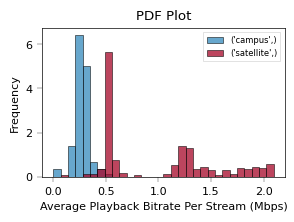

In [12]:
# plotting the throughput of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='average_bitrate',
    xlabel='Average Playback Bitrate Per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
)

# We expect this distribution to match that of the throughput of the network from the qos analysis
# It kind of does

# CONSISTENTLY the bitrate reported by the play is ~0.2Mbps lower than the one calculated by aggregating chunks for each stream

combo: ('3Mbps',), Mean: 12.08, Median: 8.0
combo: ('1.1Mbps',), Mean: 9.328, Median: 9.0


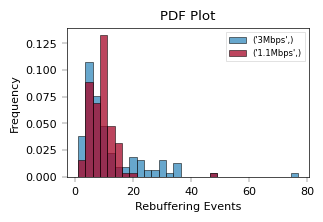

In [38]:
# plotting rebuffering events of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='rebuffering_events',
    xlabel='Rebuffering Events',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['satellite']
)

combo: ('1.1Mbps',), Mean: 84.96112800000002, Median: 63.79600000000001


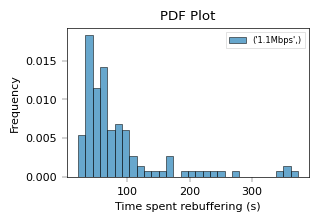

In [14]:
# plotting time spent rebuffering
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='time_rebuffering',
    xlabel='Time spent rebuffering (s)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['satellite']
)

combo: ('3Mbps',), Mean: 7.992, Median: 7.0
combo: ('1.1Mbps',), Mean: 3.32, Median: 3.0


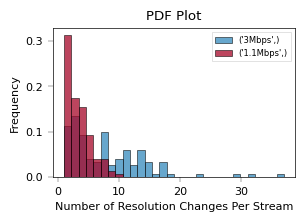

In [37]:
# plotting resolution changes of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='resolution_changes',
    xlabel='Number of Resolution Changes Per Stream',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['satellite']
)

combo: ('1.1Mbps',), Mean: 27.092976, Median: 0.0


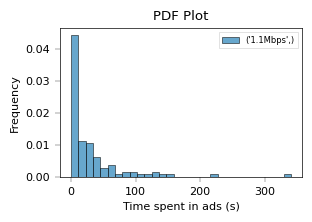

In [16]:
# plot the time in ads by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='time_spent_in_ads',
    xlabel='Time spent in ads (s)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus']
)

combo: ('IRL',), Mean: 17.09676, Median: 0.0
combo: ('MOBA',), Mean: 45.44987999999999, Median: 16.623
combo: ('SIMMULATING',), Mean: 32.24628, Median: 15.272
combo: ('SHOOTING',), Mean: 22.636479999999995, Median: 0.0
combo: ('RPG',), Mean: 18.035479999999996, Median: 0.0


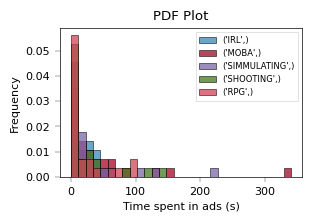

In [17]:
# plot the time in ads by category
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['category'],
    plot_key='time_spent_in_ads',
    xlabel='Time spent in ads (s)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus']
)

combo: ('3Mbps',), Mean: 0.576, Median: 1.0
combo: ('1.1Mbps',), Mean: 0.624, Median: 1.0


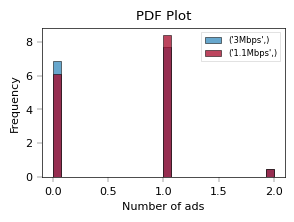

In [39]:
# plot the number of ads by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='num_ads',
    xlabel='Number of ads',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['satellite']
)

combo: ('IRL',), Mean: 0.48, Median: 0.0
combo: ('MOBA',), Mean: 0.72, Median: 1.0
combo: ('SIMMULATING',), Mean: 0.72, Median: 1.0
combo: ('SHOOTING',), Mean: 0.44, Median: 0.0
combo: ('RPG',), Mean: 0.36, Median: 0.0


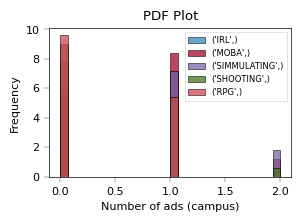

In [19]:
# plot the number of ads by category
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['category'],
    plot_key='num_ads',
    xlabel='Number of ads (campus)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus']
)

combo: ('3Mbps',), Mean: 580.384740774166, Median: 594.1463414634146
combo: ('1.1Mbps',), Mean: 269.6776396874323, Median: 259.492385786802


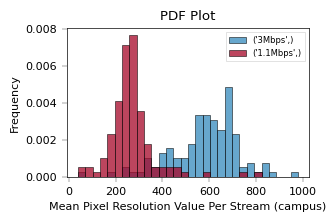

In [40]:
# plot the resolution changes by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='mean_pixel',
    xlabel='Mean Pixel Resolution Value Per Stream (campus)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['satellite']
)

combo: ('campus',), Mean: 137.89553282869102, Median: 134.34977578475338
combo: ('satellite',), Mean: 269.6776396874323, Median: 259.492385786802


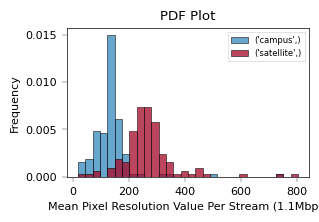

In [21]:
# plot the resolution changes by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='mean_pixel',
    xlabel='Mean Pixel Resolution Value Per Stream (1.1Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 0.27294570810844515, Median: 0.27517339393068363
combo: ('satellite',), Mean: 0.5297148870081907, Median: 0.5395918739069346


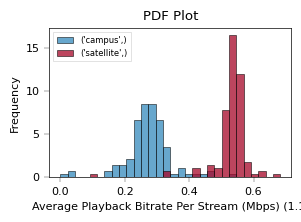

In [22]:
# plotting the throughput of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='average_bitrate',
    xlabel='Average Playback Bitrate Per Stream (Mbps) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

# We expect this distribution to match that of the throughput of the network from the qos analysis
# It kind of does

# CONSISTENTLY the bitrate reported by the play is ~0.2Mbps lower than the one calculated by aggregating chunks for each stream

combo: ('campus',), Mean: 0.544, Median: 0.0
combo: ('satellite',), Mean: 0.624, Median: 1.0


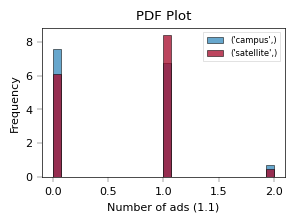

In [23]:
# plot the number of ads by category
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='num_ads',
    xlabel='Number of ads (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 20.349624074485234, Median: 19.951428571428572
combo: ('satellite',), Mean: 12.88051771192954, Median: 9.729262096774194


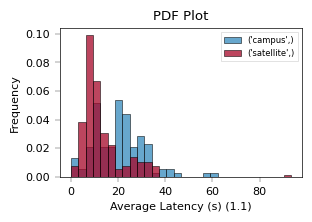

In [36]:
# plot the average latency by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='average_latency',
    xlabel='Average Latency (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 5.122230300091728, Median: 1.6425531914893616
combo: ('satellite',), Mean: 1.322823551821404, Median: 1.2805042016806722


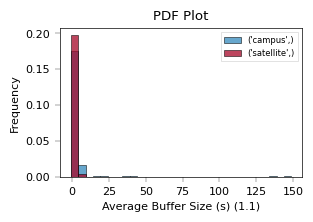

In [25]:
# plot the average buffer size by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='average_buffer',
    xlabel='Average Buffer Size (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('1.1Mbps',), Mean: 5.122230300091728, Median: 1.6425531914893616


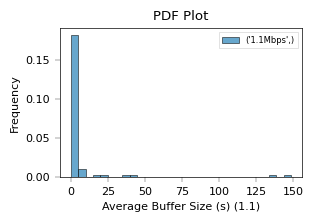

In [26]:
# plot the average buffer size by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='average_buffer',
    xlabel='Average Buffer Size (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus'],
)

combo: ('campus',), Mean: 11.832164997270489, Median: 12.357429632354632
combo: ('satellite',), Mean: 7.630373749891544, Median: 7.48681977131912


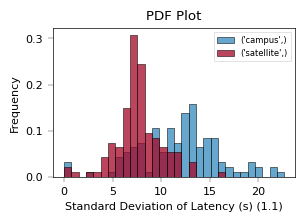

In [27]:
# plot the standard deviation of latency by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='std_latency',
    xlabel='Standard Deviation of Latency (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 5.537954207279053, Median: 3.078138632491733
combo: ('satellite',), Mean: 1.1705973294647338, Median: 1.054088700215105


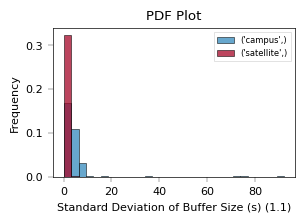

In [28]:
# plot the standard deviation of buffer size by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='std_buffer',
    xlabel='Standard Deviation of Buffer Size (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('1.1Mbps',), Mean: 5.537954207279053, Median: 3.078138632491733


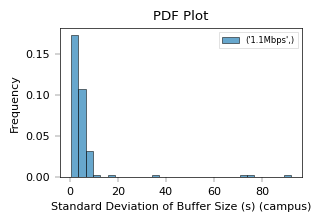

In [29]:
# plot the standard deviation of buffer size by shaping rate
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='std_buffer',
    xlabel='Standard Deviation of Buffer Size (s) (campus)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus'],
)

combo: ('campus',), Mean: 0.8027831970284224, Median: 0.8066465256797583
combo: ('satellite',), Mean: 0.9018491242970399, Median: 0.8967391304347826


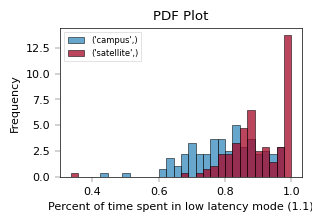

In [30]:
# plot the percent of time spent in low latency mode by network

helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='percent_low_latency',
    xlabel='Percent of time spent in low latency mode (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 16.36, Median: 15.0
combo: ('satellite',), Mean: 9.328, Median: 9.0


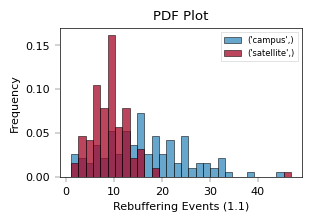

In [31]:
# plot the rebufferring events by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='rebuffering_events',
    xlabel='Rebuffering Events (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('campus',), Mean: 84.96112800000002, Median: 63.79600000000001
combo: ('satellite',), Mean: 32.214327999999995, Median: 27.192


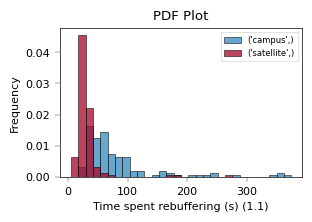

In [32]:
# plot the time spent rebuffering by network
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='time_rebuffering',
    xlabel='Time spent rebuffering (s) (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['shaping_rate'],
    filter_values=['1.1Mbps'],
)

combo: ('1.1Mbps',), Mean: 0.8027831970284224, Median: 0.8066465256797583


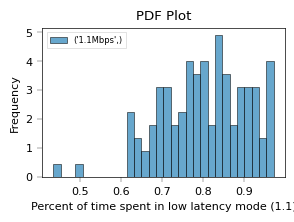

In [33]:
# plot the percent of time spent in low latency mode by network

helper.plot_multiple_cdfs(
    df=main_df,
    keys=['shaping_rate'],
    plot_key='percent_low_latency',
    xlabel='Percent of time spent in low latency mode (1.1)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['network'],
    filter_values=['campus'],
)

In [34]:
# generate plots for buffer sizes
# make bin sizes the same for all plots
# get list of available qualities
# re-run experiments to avoid the issue of non-loading in stream

In [35]:
main_df[main_df['percent_low_latency'] == 0][['file_path']].values


array([], shape=(0, 1), dtype=object)